In [2]:
import cv2
import numpy as np
import os

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

def load_mnist_data(data_path):
    def load_images_from_folder(folder):
        images = []
        labels = []
        # Iterate through each subfolder, where the folder name itself represents the label sequence
        for label_folder in os.listdir(folder):
            label_path = os.path.join(folder, label_folder)
            if os.path.isdir(label_path):
                # Label is derived from each character in the folder name (e.g., '123' → [1, 2, 3])
                label = [int(digit) for digit in label_folder]
                if label == [0]: # Skip the label '0' as the image is empty
                    continue
                # Load all images in the subfolder
                for filename in os.listdir(label_path):
                    img_path = os.path.join(label_path, filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
                    if img is not None:
                        images.append(img)
                        labels.append(label)  # Append list of digits as label
        return images, labels

    # Load data for train, val, and test splits
    train_images, train_labels = load_images_from_folder(os.path.join(data_path, 'train'))
    val_images, val_labels = load_images_from_folder(os.path.join(data_path, 'val'))
    test_images, test_labels = load_images_from_folder(os.path.join(data_path, 'test'))

    # Organize and return the data as a dictionary
    data = {
        'train': (train_images, train_labels),
        'val': (val_images, val_labels),
        'test': (test_images, test_labels)
    }
    return data

# Example usage
data_path = "../../data/interim/double_mnist"  # Replace with actual path
data = load_mnist_data(data_path)

print(f"Train: {len(data['train'][0])} images, {len(data['train'][1])} labels")
print(f"Val: {len(data['val'][0])} images, {len(data['val'][1])} labels")
print(f"Test: {len(data['test'][0])} images, {len(data['test'][1])} labels")


/home/pratyush/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Train: 12100 images, 12100 labels
Val: 2900 images, 2900 labels
Test: 4500 images, 4500 labels


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, num_classes=10, max_seq_length=3):
        """
        Args:
            images (list of np.array): List of grayscale images (e.g., loaded using OpenCV).
            labels (list of lists): Each sublist contains integers representing the sequence of digits in the image.
            num_classes (int): Number of possible classes (digits), default is 10 for MNIST digits (0-9).
            max_seq_length (int): Fixed length for label sequences. Label sequences are padded/truncated to this length.
        """
        self.images = images
        self.labels = labels
        self.num_classes = num_classes
        self.max_seq_length = max_seq_length
        self.transform = transforms.ToTensor()  # Convert image to PyTorch tensor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image and convert it to tensor
        image = self.transform(self.images[idx])
        
        # Convert label list into one-hot encoded tensor with padding
        label_seq = self.labels[idx]
        label_tensor = torch.zeros(self.max_seq_length, self.num_classes)  # Padded one-hot tensor
        
        # Populate one-hot tensor up to max_seq_length
        for i, label in enumerate(label_seq[:self.max_seq_length]):  # Truncate if sequence is longer
            label_tensor[i, label] = 1.0  # Set one-hot for each digit in sequence

        return image, label_tensor

# Convert datasets into MultiMNISTDataset
train_images, train_labels = data['train']
print(f"Train: {len(train_images)} images, {len(train_labels)} labels")
train_dataset = MultiMNISTDataset(train_images, train_labels)

test_images, test_labels = data['test']
print(f"Test: {len(test_images)} images, {len(test_labels)} labels")
test_dataset = MultiMNISTDataset(test_images, test_labels)

val_images, val_labels = data['val']
print(f"Val: {len(val_images)} images, {len(val_labels)} labels")
val_dataset = MultiMNISTDataset(val_images, val_labels)

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Checking a batch from train_loader
images, labels = next(iter(train_loader))
print(f"Batch of images shape: {images.shape}")
print(f"Batch of labels shape: {labels.shape}")




Train: 12100 images, 12100 labels
Test: 4500 images, 4500 labels
Val: 2900 images, 2900 labels
Batch of images shape: torch.Size([32, 1, 128, 128])
Batch of labels shape: torch.Size([32, 3, 10])


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


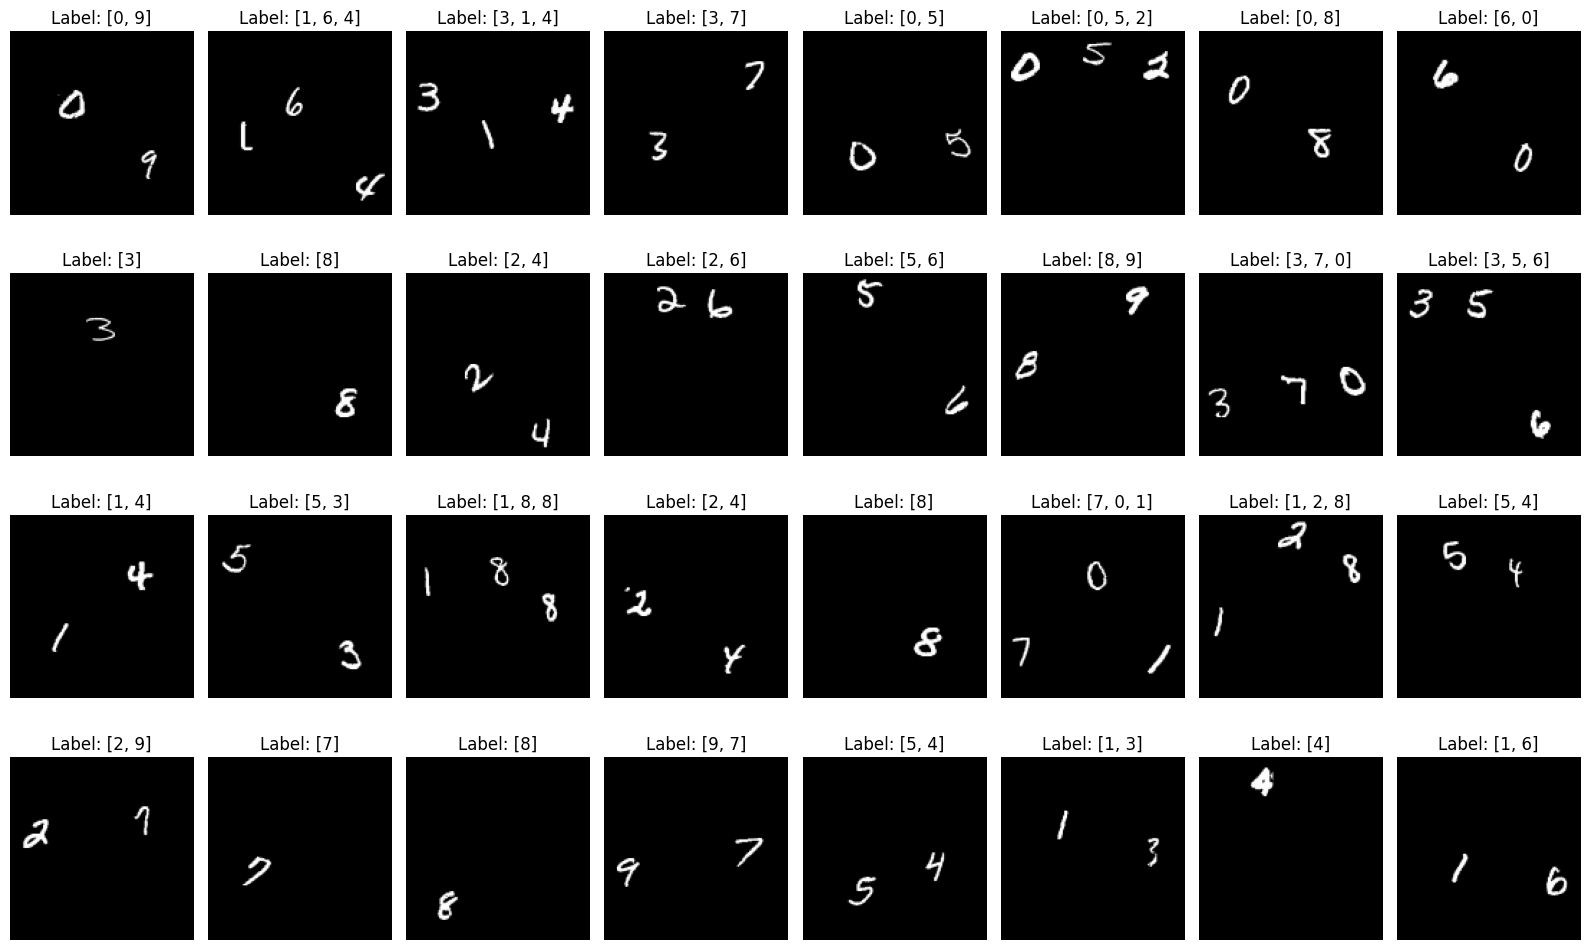

In [6]:
def plot_batch_with_labels(images, labels, max_seq_length=5):
    """
    Plot a batch of images with corresponding labels.

    Args:
        images (torch.Tensor): Batch of images (batch_size, 1, H, W).
        labels (torch.Tensor): Batch of one-hot encoded labels (batch_size, max_seq_length, num_classes).
        max_seq_length (int): The fixed length used for label sequences.
    """
    batch_size = images.size(0)
    num_classes = labels.size(-1)

    # Convert one-hot encoded labels to readable sequence format
    decoded_labels = []
    print(labels[4])
    for label_seq in labels:
        decoded_seq = []
        for one_hot in label_seq:
            if one_hot.sum() > 0:  # If not padded
                decoded_seq.append(torch.argmax(one_hot).item())
        decoded_labels.append(decoded_seq)

    # Plot each image with its corresponding label
    plt.figure(figsize=(16, 10))
    for i in range(batch_size):
        plt.subplot(4, 8, i + 1)  # Display up to 32 images in a 4x8 grid
        plt.imshow(images[i].squeeze(0), cmap='gray')
        plt.title(f"Label: {decoded_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

for images, labels in train_loader:
    plot_batch_with_labels(images, labels)
    break

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiLabelCNN(nn.Module):
    """
    CNN architecture for multi-label digit classification.
    Each image can contain up to 5 digits, and each position needs a probability distribution over 0-9.
    
    Architecture features:
    - Deeper network to handle complex spatial relationships between multiple digits
    - Global average pooling to handle variable digit positions
    - Multiple output heads for each digit position
    """
    
    def __init__(self, num_positions: int = 5, num_classes: int = 10):
        """
        Initialize the MultiLabel CNN.
        
        Args:
            num_positions: Number of possible digit positions (default: 5)
            num_classes: Number of possible digits (default: 10 for digits 0-9)
        """
        super(MultiLabelCNN, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),
            
            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),
            
            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )
        
        # Global average pooling to handle variable digit positions
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Shared fully connected layers
        self.fc_shared = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        
        # Separate output heads for each digit position
        self.digit_classifiers = nn.ModuleList([
            nn.Linear(256, num_classes) for _ in range(num_positions)
        ])
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize model weights using He initialization."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the network.
        
        Args:
            x: Input tensor of shape (batch_size, 1, height, width)
            
        Returns:
            List of tensors, each of shape (batch_size, num_classes),
            representing probability distributions over digits for each position
        """
        # Extract features
        x = self.features(x)
        
        # Global average pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # Shared fully connected layers
        x = self.fc_shared(x)
        
        # Get predictions for each digit position
        # Note: No activation function is applied here as we'll use CrossEntropyLoss
        digit_preds = [classifier(x) for classifier in self.digit_classifiers]
        
        # Stack predictions along new dimension
        # Shape: (batch_size, num_positions, num_classes)
        return torch.stack(digit_preds, dim=1)


In [83]:
def train_multilabel_cnn(model, train_loader, val_loader, device, num_epochs=10):
    """
    Training function for MultiLabel CNN with validation loss tracking.
    
    Args:
        model: The MultiLabel CNN model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        device: Device to train on (CPU/GPU)
        num_epochs: Number of training epochs
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    model = model.to(device)
    best_val_loss = float('inf')
    
    def evaluate(loader):
        model.eval()
        total_loss = 0
        num_batches = 0
        
        with torch.no_grad():
            for images, targets in loader:
                images = images.to(device)
                targets = targets.to(device)
                outputs = model(images)
                
                # Calculate loss for each position
                batch_loss = 0
                for pos in range(targets.size(1)):
                    batch_loss += criterion(outputs[:, pos], targets[:, pos])
                
                total_loss += batch_loss.item()
                num_batches += 1
        
        return total_loss / num_batches
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        num_train_batches = 0
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            images = images.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            # Calculate loss for each position
            loss = 0
            for pos in range(targets.size(1)):
                loss += criterion(outputs[:, pos], targets[:, pos])
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            num_train_batches += 1
            
            if (batch_idx + 1) % 100 == 0:
                current_train_loss = train_loss / num_train_batches
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Step [{batch_idx+1}/{len(train_loader)}], '
                      f'Training Loss: {current_train_loss:.4f}')
        
        # Calculate average training loss for the epoch
        avg_train_loss = train_loss / num_train_batches
        
        # Validation phase
        val_loss = evaluate(val_loader)
        
        # Print epoch summary
        print(f'\nEpoch [{epoch+1}/{num_epochs}] Summary:')
        print(f'Average Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print(f'New best validation loss: {val_loss:.4f}')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, 'best_model.pth')
        
        print('-' * 60 + '\n')

# Example usage
if __name__ == '__main__':
    model = MultiLabelCNN(num_positions=3, num_classes=10)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Assuming you have train_loader and val_loader defined
    train_multilabel_cnn(model, train_loader, val_loader, device, num_epochs=10)


Epoch [1/10], Step [100/379], Training Loss: 5.5702
Epoch [1/10], Step [200/379], Training Loss: 5.1568
Epoch [1/10], Step [300/379], Training Loss: 5.0041

Epoch [1/10] Summary:
Average Training Loss: 4.9467
Validation Loss: 4.9522
New best validation loss: 4.9522
------------------------------------------------------------

Epoch [2/10], Step [100/379], Training Loss: 4.6688
Epoch [2/10], Step [200/379], Training Loss: 4.6791
Epoch [2/10], Step [300/379], Training Loss: 4.6689

Epoch [2/10] Summary:
Average Training Loss: 4.6674
Validation Loss: 5.1145
------------------------------------------------------------

Epoch [3/10], Step [100/379], Training Loss: 4.6561
Epoch [3/10], Step [200/379], Training Loss: 4.6714
Epoch [3/10], Step [300/379], Training Loss: 4.6354

Epoch [3/10] Summary:
Average Training Loss: 4.6302
Validation Loss: 4.9158
New best validation loss: 4.9158
------------------------------------------------------------

Epoch [4/10], Step [100/379], Training Loss: 4.60

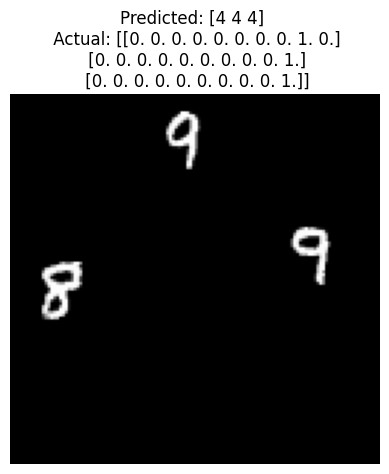

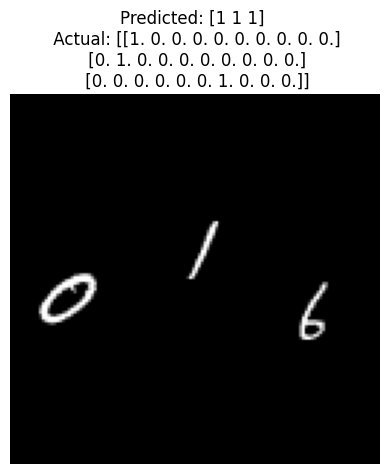

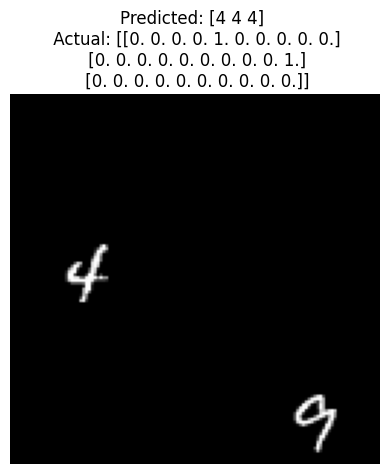

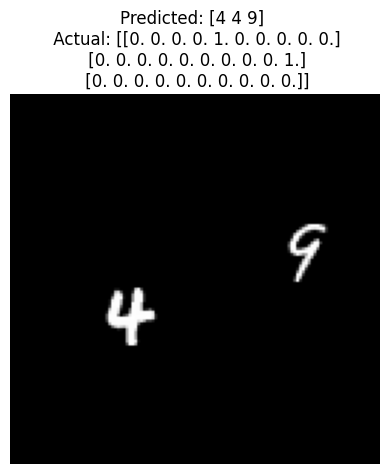

In [84]:
# print one prediction from test_loader
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    

    # print for the whole batch plot the image and the predicted and actual labels
    for i in range(1,32,8):
        plt.imshow(images[i].squeeze(0).cpu().numpy(), cmap='gray')
        plt.title(f"Predicted: {torch.argmax(outputs[i], dim=1).cpu().numpy()} \n Actual: {labels[i].cpu().numpy()}")
        plt.axis('off')
        plt.show()

    break


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiLabelCNNVariable(nn.Module):
    """
    CNN for multi-label digit classification that handles variable number of digits.
    Each image can contain up to 5 digits, with empty positions allowed.
    """
    
    def __init__(self, max_digits: int = 5, num_classes: int = 10):
        """
        Initialize the network.
        
        Args:
            max_digits: Maximum number of digit positions
            num_classes: Number of possible digits (0-9)
        """
        super(MultiLabelCNNVariable, self).__init__()
        
        self.max_digits = max_digits
        self.num_classes = num_classes
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )
        
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Shared fully connected layers
        self.fc_shared = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        
        # Digit classifiers for each position
        self.digit_classifiers = nn.ModuleList([
            nn.Linear(256, num_classes) for _ in range(max_digits)
        ])
        
        # Presence detector for each position
        self.presence_detectors = nn.ModuleList([
            nn.Linear(256, 1) for _ in range(max_digits)
        ])
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize model weights using He initialization."""
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> tuple:
        """
        Forward pass of the network.
        
        Args:
            x: Input tensor of shape (batch_size, 1, height, width)
            
        Returns:
            tuple containing:
                - digit_preds: Tensor of shape (batch_size, max_digits, num_classes)
                - presence_preds: Tensor of shape (batch_size, max_digits)
        """
        # Extract features
        x = self.features(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # Shared features
        shared_features = self.fc_shared(x)
        
        # Get digit predictions and presence predictions
        digit_preds = [classifier(shared_features) for classifier in self.digit_classifiers]
        presence_preds = [detector(shared_features) for detector in self.presence_detectors]
        
        # Stack predictions
        digit_preds = torch.stack(digit_preds, dim=1)  # (batch_size, max_digits, num_classes)
        presence_preds = torch.stack(presence_preds, dim=1)  # (batch_size, max_digits)
        presence_preds = torch.sigmoid(presence_preds.squeeze(-1))  # Convert to probabilities
        
        return digit_preds, presence_preds

def train_variable_digit_cnn(model, train_loader, val_loader, device, num_epochs=10):
    """
    Training function that handles variable number of digits.
    """
    digit_criterion = nn.CrossEntropyLoss(reduction='none')
    presence_criterion = nn.BCELoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters())
    
    model = model.to(device)
    best_val_loss = float('inf')
    
    def compute_loss(outputs, targets):
        digit_preds, presence_preds = outputs
        
        # Create presence mask from targets
        # A position has a digit if any class has a 1 in the one-hot encoding
        presence_mask = (targets.sum(dim=-1) > 0).float()
        
        # Get digit predictions for each position
        digit_loss = 0
        num_valid = 0
        
        for pos in range(targets.size(1)):
            # Only compute loss for positions that should have digits
            pos_mask = presence_mask[:, pos]
            if pos_mask.sum() > 0:
                # Get predicted class for each valid position
                pos_loss = digit_criterion(digit_preds[:, pos], targets[:, pos].argmax(dim=-1))
                # Apply mask to only include valid positions
                digit_loss += (pos_loss * pos_mask).sum()
                num_valid += pos_mask.sum()
        
        # Normalize digit loss by number of valid positions
        if num_valid > 0:
            digit_loss = digit_loss / num_valid
        
        # Compute presence loss
        presence_loss = presence_criterion(presence_preds, presence_mask).mean()
        
        # Combine losses
        total_loss = digit_loss + presence_loss
        
        return total_loss, digit_loss, presence_loss
    
    def evaluate(loader):
        model.eval()
        total_loss = 0
        num_batches = 0
        
        with torch.no_grad():
            for images, targets in loader:
                images = images.to(device)
                targets = targets.to(device)
                outputs = model(images)
                loss, _, _ = compute_loss(outputs, targets)
                total_loss += loss.item()
                num_batches += 1
        
        return total_loss / num_batches
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        num_batches = 0
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            images = images.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss, digit_loss, presence_loss = compute_loss(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            num_batches += 1
            
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Step [{batch_idx+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f} '
                      f'(Digit: {digit_loss.item():.4f}, '
                      f'Presence: {presence_loss.item():.4f})')
        
        # Compute validation loss
        val_loss = evaluate(val_loader)
        
        # Print epoch summary
        avg_train_loss = train_loss / num_batches
        print(f'\nEpoch [{epoch+1}/{num_epochs}] Summary:')
        print(f'Average Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print(f'New best validation loss: {val_loss:.4f}')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, 'best_variable_digit_model.pth')
        
        print('-' * 60 + '\n')

def predict_with_confidence(model, image, confidence_threshold=0.5):
    """
    Make predictions and only return digits for positions with high confidence.
    """
    model.eval()
    with torch.no_grad():
        digit_preds, presence_preds = model(image)
        
        # Get predicted digits
        digit_probs = F.softmax(digit_preds, dim=-1)
        predicted_digits = digit_probs.argmax(dim=-1)
        
        # Only keep predictions where presence probability exceeds threshold
        valid_positions = presence_preds > confidence_threshold
        
        # Create final predictions
        final_predictions = []
        for i in range(valid_positions.size(1)):
            if valid_positions[0, i]:
                final_predictions.append(predicted_digits[0, i].item())
        
        return final_predictions

# Example usage
if __name__ == '__main__':
    model = MultiLabelCNNVariable(max_digits=5, num_classes=10)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Assuming you have train_loader and val_loader defined
    train_variable_digit_cnn(model, train_loader, val_loader, device, num_epochs=10)

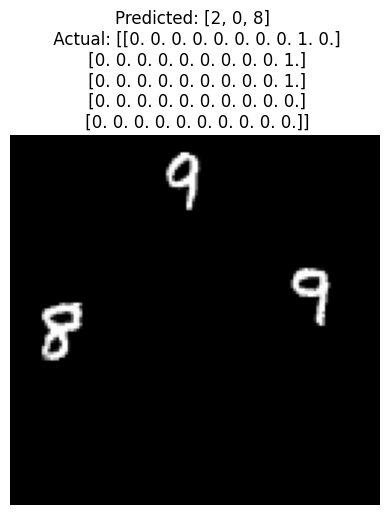

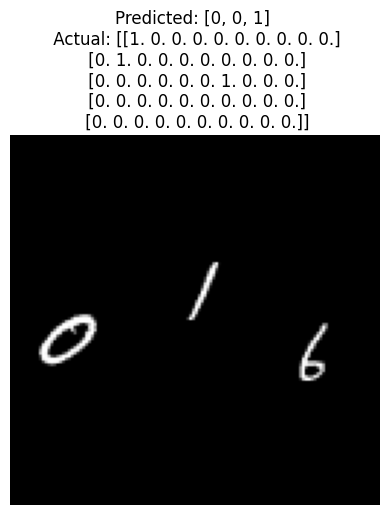

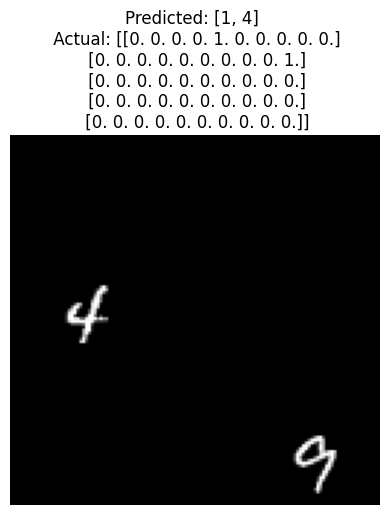

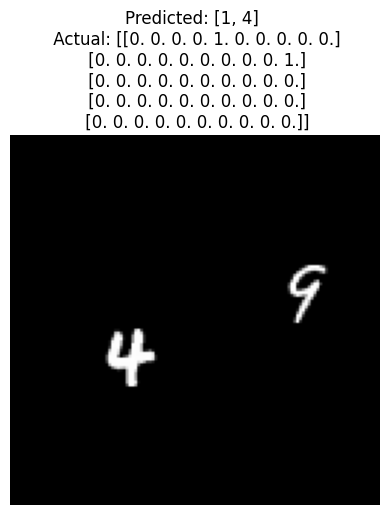

In [63]:
# print one prediction from test_loader
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    

    # print for the whole batch plot the image and the predicted and actual labels
    for i in range(1,32,8):
        plt.imshow(images[i].squeeze(0).cpu().numpy(), cmap='gray')
        plt.title(f"Predicted: {predict_with_confidence(model, images[i].unsqueeze(0))} \n Actual: {labels[i].cpu().numpy()}")
        plt.axis('off')
        plt.show()

    break


In [67]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Define hyperparameter configurations to test
hyperparameter_configs = [
    {"lr": 0.001, "dropout": 0.5, "optimizer": "Adam"},
    {"lr": 0.0005, "dropout": 0.3, "optimizer": "Adam"},
    {"lr": 0.001, "dropout": 0.4, "optimizer": "SGD"},
    {"lr": 0.002, "dropout": 0.5, "optimizer": "Adam"},
    {"lr": 0.0001, "dropout": 0.3, "optimizer": "RMSprop"},
]

def train_variable_digit_cnn(model, train_loader, val_loader, device, config, num_epochs=10):
    """
    Training function with hyperparameter tuning.
    """
    # Set up optimizer
    if config["optimizer"] == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    elif config["optimizer"] == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=config["lr"])
    elif config["optimizer"] == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=config["lr"])
    
    # Set dropout rate dynamically
    for module in model.modules():
        if isinstance(module, nn.Dropout) or isinstance(module, nn.Dropout2d):
            module.p = config["dropout"]
    
    digit_criterion = nn.CrossEntropyLoss(reduction='none')
    presence_criterion = nn.BCELoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters())
    val_loss_history, train_loss_history = [], []

    def compute_loss(outputs, targets):
        digit_preds, presence_preds = outputs
        
        # Create presence mask from targets
        # A position has a digit if any class has a 1 in the one-hot encoding
        presence_mask = (targets.sum(dim=-1) > 0).float()
        
        # Get digit predictions for each position
        digit_loss = 0
        num_valid = 0
        
        for pos in range(targets.size(1)):
            # Only compute loss for positions that should have digits
            pos_mask = presence_mask[:, pos]
            if pos_mask.sum() > 0:
                # Get predicted class for each valid position
                pos_loss = digit_criterion(digit_preds[:, pos], targets[:, pos].argmax(dim=-1))
                # Apply mask to only include valid positions
                digit_loss += (pos_loss * pos_mask).sum()
                num_valid += pos_mask.sum()
        
        # Normalize digit loss by number of valid positions
        if num_valid > 0:
            digit_loss = digit_loss / num_valid
        
        # Compute presence loss
        presence_loss = presence_criterion(presence_preds, presence_mask).mean()
        
        # Combine losses
        total_loss = digit_loss + presence_loss
        
        return total_loss, digit_loss, presence_loss

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss, _, _ = compute_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Track average training loss
        train_loss = running_loss / len(train_loader)
        train_loss_history.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss, _, _ = compute_loss(outputs, labels)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return train_loss_history, val_loss_history

# Run experiments and store results
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = {}

for config in hyperparameter_configs:
    print(f"Training with config: {config}")
    model = MultiLabelCNNVariable(max_digits=5, num_classes=10).to(device)
    
    train_loss, val_loss = train_variable_digit_cnn(model, train_loader, val_loader, device, config, num_epochs=10)
    
    config_key = f"LR: {config['lr']}, Dropout: {config['dropout']}, Optimizer: {config['optimizer']}"
    results[config_key] = {"train_loss": train_loss, "val_loss": val_loss}

    print()


Training with config: {'lr': 0.001, 'dropout': 0.5, 'optimizer': 'Adam'}
Epoch 1/10, Train Loss: 3.0632, Val Loss: 2.5462
Epoch 2/10, Train Loss: 2.5348, Val Loss: 2.5265
Epoch 3/10, Train Loss: 2.4816, Val Loss: 2.6482
Epoch 4/10, Train Loss: 2.4481, Val Loss: 2.9357
Epoch 5/10, Train Loss: 2.4237, Val Loss: 3.1064
Epoch 6/10, Train Loss: 2.3985, Val Loss: 3.5509
Epoch 7/10, Train Loss: 2.3822, Val Loss: 2.8024
Epoch 8/10, Train Loss: 2.3660, Val Loss: 2.9124
Epoch 9/10, Train Loss: 2.3581, Val Loss: 3.0717
Epoch 10/10, Train Loss: 2.3434, Val Loss: 2.7399

Training with config: {'lr': 0.0005, 'dropout': 0.3, 'optimizer': 'Adam'}
Epoch 1/10, Train Loss: 2.6310, Val Loss: 2.5882
Epoch 2/10, Train Loss: 2.3801, Val Loss: 2.8582
Epoch 3/10, Train Loss: 2.3370, Val Loss: 3.0693
Epoch 4/10, Train Loss: 2.2962, Val Loss: 2.6985
Epoch 5/10, Train Loss: 2.1982, Val Loss: 2.7487
Epoch 6/10, Train Loss: 2.1190, Val Loss: 2.8670
Epoch 7/10, Train Loss: 2.0629, Val Loss: 2.8715
Epoch 8/10, Train 

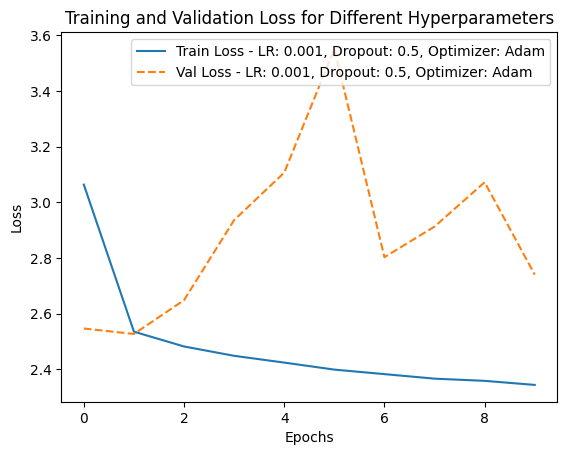

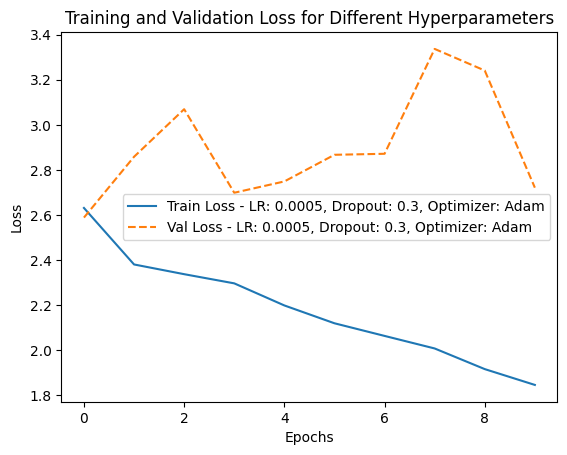

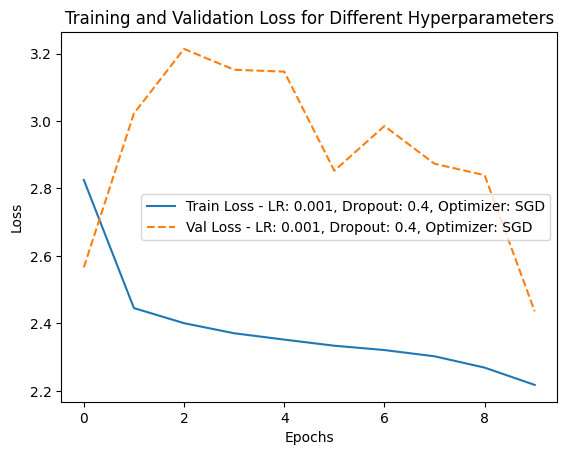

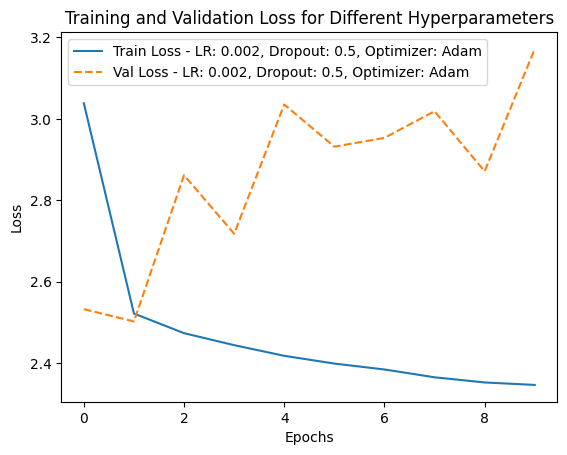

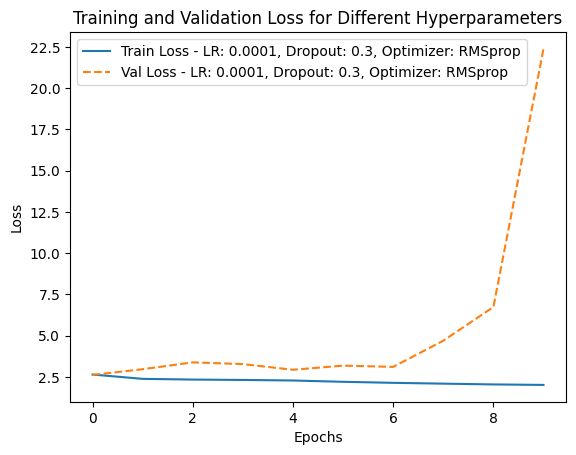

Best Hyperparameters: LR: 0.001, Dropout: 0.4, Optimizer: SGD


In [72]:
# Plot results
# plt.figure(figsize=(12, 8))
for key, data in results.items():
    plt.plot(data["train_loss"], label=f"Train Loss - {key}")
    plt.plot(data["val_loss"], label=f"Val Loss - {key}", linestyle="--")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss for Different Hyperparameters")
    plt.show()

# Finding the best model based on minimum validation loss
best_config = min(results, key=lambda x: min(results[x]["val_loss"]))
print(f"Best Hyperparameters: {best_config}")

In [70]:
# save the results into a csv
import pandas as pd
results_df = pd.DataFrame(results)
results_df.to_csv("hyperparameter_results.csv")


In [14]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

hyperparameter_configs = [{"lr": 0.001, "dropout": 0.5, "optimizer": "Adam"}]

def train_variable_digit_cnn(model, train_loader, val_loader, device, config, num_epochs=10):
    """
    Training function with hyperparameter tuning.
    """
    # Set up optimizer
    if config["optimizer"] == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    elif config["optimizer"] == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=config["lr"])
    elif config["optimizer"] == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=config["lr"])
    
    # Set dropout rate dynamically
    for module in model.modules():
        if isinstance(module, nn.Dropout) or isinstance(module, nn.Dropout2d):
            module.p = config["dropout"]
    
    digit_criterion = nn.CrossEntropyLoss(reduction='none')
    presence_criterion = nn.BCELoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters())
    val_loss_history, train_loss_history = [], []

    def compute_loss(outputs, targets):
        digit_preds, presence_preds = outputs
        
        # Create presence mask from targets
        # A position has a digit if any class has a 1 in the one-hot encoding
        presence_mask = (targets.sum(dim=-1) > 0).float()
        
        # Get digit predictions for each position
        digit_loss = 0
        num_valid = 0
        
        for pos in range(targets.size(1)):
            # Only compute loss for positions that should have digits
            pos_mask = presence_mask[:, pos]
            if pos_mask.sum() > 0:
                # Get predicted class for each valid position
                pos_loss = digit_criterion(digit_preds[:, pos], targets[:, pos].argmax(dim=-1))
                # Apply mask to only include valid positions
                digit_loss += (pos_loss * pos_mask).sum()
                num_valid += pos_mask.sum()
        
        # Normalize digit loss by number of valid positions
        if num_valid > 0:
            digit_loss = digit_loss / num_valid
        
        # Compute presence loss
        presence_loss = presence_criterion(presence_preds, presence_mask).mean()
        
        # Combine losses
        total_loss = digit_loss + presence_loss
        
        return total_loss, digit_loss, presence_loss

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss, _, _ = compute_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Track average training loss
        train_loss = running_loss / len(train_loader)
        train_loss_history.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss, _, _ = compute_loss(outputs, labels)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return train_loss_history, val_loss_history

# Run experiments and store results
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = {}

for config in hyperparameter_configs:
    print(f"Training with config: {config}")
    model = MultiLabelCNNVariable(max_digits=3, num_classes=10).to(device)
    
    train_loss, val_loss = train_variable_digit_cnn(model, train_loader, val_loader, device, config, num_epochs=10)
    
    config_key = f"LR: {config['lr']}, Dropout: {config['dropout']}, Optimizer: {config['optimizer']}"
    results[config_key] = {"train_loss": train_loss, "val_loss": val_loss}

    print()


Training with config: {'lr': 0.001, 'dropout': 0.5, 'optimizer': 'Adam'}
Epoch 1/10, Train Loss: 3.2461, Val Loss: 2.6717
Epoch 2/10, Train Loss: 2.6251, Val Loss: 2.7020
Epoch 3/10, Train Loss: 2.5463, Val Loss: 2.9293
Epoch 4/10, Train Loss: 2.5015, Val Loss: 3.0815
Epoch 5/10, Train Loss: 2.4678, Val Loss: 3.0557
Epoch 6/10, Train Loss: 2.4394, Val Loss: 2.7471
Epoch 7/10, Train Loss: 2.4126, Val Loss: 2.8629
Epoch 8/10, Train Loss: 2.3954, Val Loss: 2.9588
Epoch 9/10, Train Loss: 2.3871, Val Loss: 2.7414
Epoch 10/10, Train Loss: 2.3715, Val Loss: 3.0777



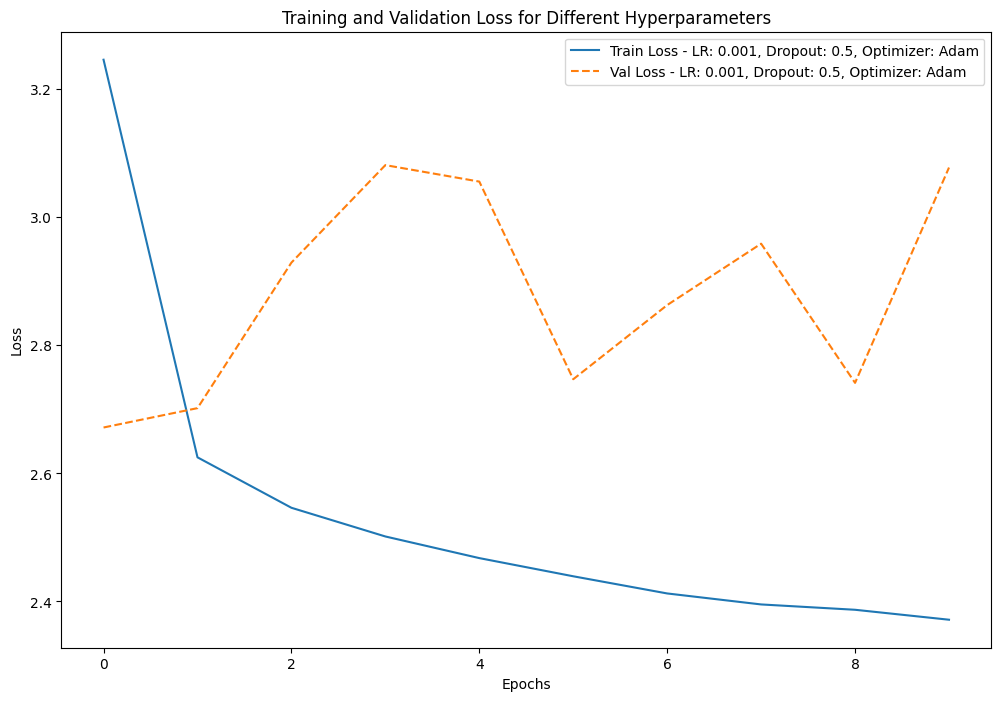

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for key, data in results.items():
    plt.plot(data["train_loss"], label=f"Train Loss - {key}")
    plt.plot(data["val_loss"], label=f"Val Loss - {key}", linestyle="--")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss for Different Hyperparameters")
plt.show()


In [31]:
import torch
import torch.nn.functional as F

def evaluate_model(model, data_loader, device):
    """
    Calculate exact match accuracy and Hamming accuracy for multi-label classification.
    """
    model.eval()
    exact_match_total, hamming_correct, hamming_total = 0, 0, 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            targets = targets.to(device)
            
            digit_preds, presence_preds = model(images)
            predicted_digits = digit_preds.argmax(dim=-1)  # Shape: (batch_size, max_digits)
            presence_preds = (presence_preds > 0.5).int()  # Binary presence prediction
            targets = targets.argmax(dim=-1)  # Convert one-hot to class index
            
            # Calculate exact match accuracy
            exact_match = (predicted_digits == targets).all(dim=1).float().mean().item()
            exact_match_total += exact_match * images.size(0)
            
            # Calculate Hamming accuracy manually
            hamming_correct += (predicted_digits == targets).float().sum().item()
            hamming_total += targets.numel()  # Total number of label predictions made

    exact_match_accuracy = exact_match_total / len(data_loader.dataset)
    hamming_accuracy = hamming_correct / hamming_total
    return exact_match_accuracy, hamming_accuracy

# Evaluate on train, validation, and test sets
train_exact, train_hamming = evaluate_model(model, train_loader, device)
val_exact, val_hamming = evaluate_model(model, val_loader, device)
test_exact, test_hamming = evaluate_model(model, test_loader, device)

print(f"Exact Match Accuracy (Train): {train_exact:.4f}")
print(f"Hamming Accuracy (Train): {train_hamming:.4f}")
print(f"Exact Match Accuracy (Validation): {val_exact:.4f}")
print(f"Hamming Accuracy (Validation): {val_hamming:.4f}")
print(f"Exact Match Accuracy (Test): {test_exact:.4f}")
print(f"Hamming Accuracy (Test): {test_hamming:.4f}")


Exact Match Accuracy (Train): 0.0004
Hamming Accuracy (Train): 0.0855
Exact Match Accuracy (Validation): 0.0000
Hamming Accuracy (Validation): 0.0614
Exact Match Accuracy (Test): 0.0000
Hamming Accuracy (Test): 0.0256


**Answer:**

This model does **not require an additional activation function** after the last linear layer. Here's why:

1. **Difference Between This Model and a Simple Classifier**:
   - The previous CNN classifier likely performed **single-label classification**, where there was one output per input image (e.g., a single digit label). In such cases, a **softmax activation** might be applied to the output layer to convert logits into probabilities.
   - This model, however, performs **multi-label, multi-class classification**, predicting probabilities for multiple digit positions independently (e.g., predicting a digit at each of 5 positions). Each output "head" produces raw logits for 10 classes, and we use a **loss function that directly handles logits**.

2. **Why No Activation Function Is Needed?**
   - The model uses **CrossEntropyLoss** during training, which **combines softmax activation and negative log-likelihood loss in one step**. This means that applying a softmax function manually would be redundant and may cause numerical instability during training.

3. **Justification for Softmax (If Used)**:
   - If `CrossEntropyLoss` were not used, you would need to apply **softmax** to the output of each linear layer to transform the logits into probabilities. Softmax ensures that the output values for each digit position sum to 1, representing valid probability distributions.

---
- CrossEntropyLoss handles both softmax activation and loss computation.
- If softmax were applied manually, it would result in redundant computation and possible numerical instability.